In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
import csv

data = open('../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

vol = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    vol[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

Great — we're done with setup. 

# Analysis — Week 2


## 1. Layers of Cortex
Let's look closer at the layers of cortex and determine their boundaries statistically.

In [5]:
y_sum = [0] * len(vol[0,:,0])
for i in range(len(vol[0,:,0])):
    y_sum[i] = sum(sum(vol[:,i,:]))

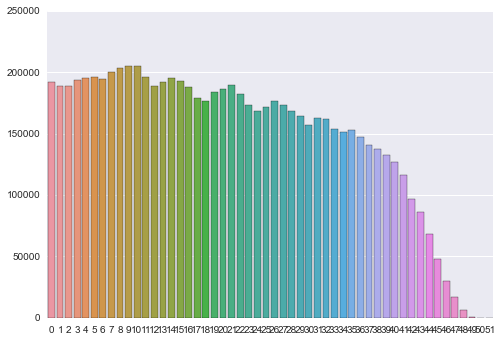

In [6]:
sns.barplot(x=range(len(y_sum)), y=y_sum)

Above, we see a histogram of `y_sum` that indicates that there is a local minimum at the 12th layer of y-sampling, which colocates with where we anticipate seeing the boundary between layers I and II. Here is the biological substantiation:

![image](https://cloud.githubusercontent.com/assets/693511/14183355/e9eafbd6-f73d-11e5-9769-8ce69e30774b.png)

As we can see, at about 1/3 of the 'depth' into cortex is the boundary to layer II.

# 2. Generate local minima by subsection of cortex
We'll use these local minima to decide where to draw the lines between layers of cortex on the imagery.

In [7]:
from scipy.signal import argrelextrema
def local_minima(a):
    return argrelextrema(a, np.less)

whole_volume_minima = local_minima(np.array(y_sum))

In [8]:
whole_volume_minima

(array([ 2,  6, 12, 18, 24, 30, 34]),)

Now let's examine smaller chunks of the volume:

In [9]:
CHUNK_SIZE = 25
sections = [(i*CHUNK_SIZE, (i+1)*CHUNK_SIZE) for i in range(len(vol[:,0,0]) / CHUNK_SIZE)]

histogram = {}

for s in sections:
    section = vol[s[0]:s[1]]
    
    histogram[s] = [0] * len(vol[0,:,0])
    for i in range(len(vol[0,:,0])):
        histogram[s][i] = sum(sum(vol[s[0]:s[1],i,:]))

In [10]:
h_local_minima = []
for t, h in histogram.iteritems():
    h_local_minima.extend([i for i in local_minima(np.array(h))])

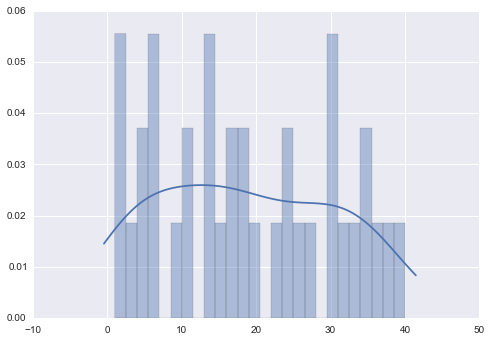

In [11]:
total_histogram = [item for sublist in h_local_minima for item in sublist]
sns.distplot(total_histogram, bins=26)

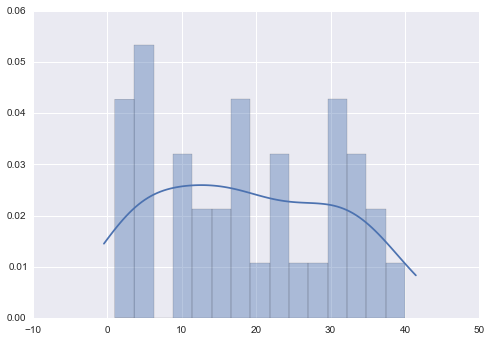

In [12]:
sns.distplot(total_histogram, bins=15)

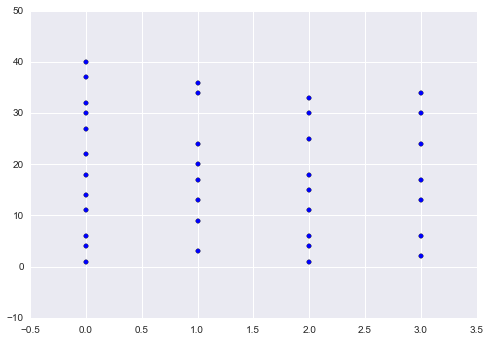

In [52]:
scatterable = []
i = 0
for h in h_local_minima:
    [scatterable.append([i, m]) for m in h]
    i += 1

plt.scatter(x=[s[0] for s in scatterable], y=[s[1] for s in scatterable])

This coincides with our understanding that our sample space extends midway into layer 4, but covers all of layers 1, 2, and 3. 

> To play with these parameters, try changing `CHUNK_SIZE` to other values to change how small the sections of subcortex are.

## 3. Clustering and Selecting "Real" Cortex Boundaries
We'll flatten this list in 2D and then pick centers of mass for each local-minima cluster.

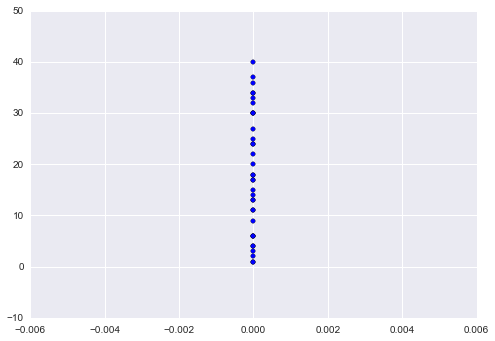

In [14]:
from sklearn.cluster import KMeans

plt.scatter([0] * len(total_histogram), total_histogram)

In [15]:
NUM_CLUSTERS = 3

k3cluster = KMeans(n_clusters=NUM_CLUSTERS)
total_histogram.sort()
clusters_for_th = k3cluster.fit_predict(np.array(total_histogram).reshape(-1, 1))

Now we can get the centroids from these clusters. I wish I understood what I was doing.

In [16]:
clusters = { n: [] for n in range(NUM_CLUSTERS) }

for i in range(len(total_histogram)):
    clusters[clusters_for_th[i]].append(total_histogram[i]) 

In [17]:
clusters

{0: [13, 13, 14, 15, 17, 17, 18, 18, 20, 22, 24, 24, 25],
 1: [27, 30, 30, 30, 32, 33, 34, 34, 36, 37, 40],
 2: [1, 1, 2, 3, 4, 4, 6, 6, 6, 9, 11, 11]}

Now we can assume that the means of these clusters are the actual boundaries between cortex.

In [18]:
cluster_means = [np.mean(v) for _, v in clusters.iteritems() ]

In [19]:
cluster_means

[18.46153846153846, 33.0, 5.333333333333333]

## 4. Verifying our statistical boundaries against an image
We know that our data are taken from `bock11` on `ndstore`, so... Now let's overlay those averages over our image.

In [48]:
from PIL import Image
import urllib, cStringIO

file = cStringIO.StringIO(urllib.urlopen("http://openconnecto.me/ocp/ca/bock11/image/xy/7/350,850/50,936/2917/").read())
img = Image.open(file)
img_array = np.array(img)

In [49]:
cluster_means = np.array(cluster_means)
cluster_means_mapped = (cluster_means / vol.shape[1]) * img_array.shape[0]
for i in cluster_means_mapped:
    img_array[[i, i+1, i-1], :] -= 50

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


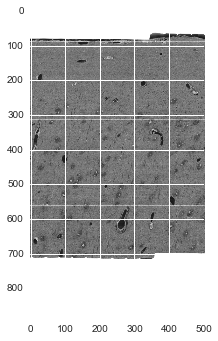

In [55]:
# Image.fromarray(img_array)
plt.imshow(img_array)
plt.scatter(x=[r[0] for row in r], y=[r[1] for row in r], r=[r[2] for ])

## 5. Finding Descending Processes in Cortex
We should be able to find collections of high synaptic density in regions where processes exist. We can use a simple variant of a k-means algorithm to find these clusters.

To do this, we'll first flatten along the y-plane to find descending processes.

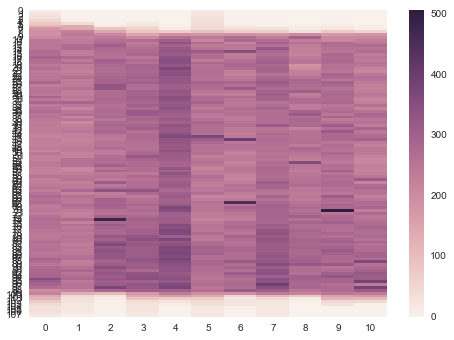

In [23]:
yflat = np.amax(vol, axis=1)
frame_y = pd.DataFrame(yflat)
sns.heatmap(frame_y)

In [24]:
processkmeans = KMeans()
print yflat
processkmeans.fit_predict(yflat)

[[ 14.   0.   0. ...,   0.   1.   0.]
 [ 29.   0.   0. ...,   0.   0.   0.]
 [ 32.   3.   0. ...,   0.   0.   0.]
 ..., 
 [ 36.  16.   1. ...,   0.   0.   0.]
 [ 29.  15.   0. ...,   0.   0.   0.]
 [ 21.   4.   0. ...,   0.   0.   0.]]


array([1, 1, 1, 1, 1, 3, 3, 3, 5, 2, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 2, 0, 6, 6, 2, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 6, 6, 6, 2, 2, 7,
       2, 6, 2, 2, 2, 6, 6, 2, 6, 6, 6, 2, 2, 2, 6, 2, 6, 6, 2, 6, 6, 7, 6,
       0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 4, 4, 1, 1, 1, 1, 1, 1], dtype=int32)

## Next steps
I want to run this cluster-finding algorithm in 3D next to see if we can isolate horizontal processes as well.